In [7]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input

In [8]:
gray_images = np.load("/kaggle/input/image-colorization/l/gray_scale.npy")
ab_images = np.load("/kaggle/input/image-colorization/ab/ab/ab1.npy")
#gray_images = gray_images[20000:]

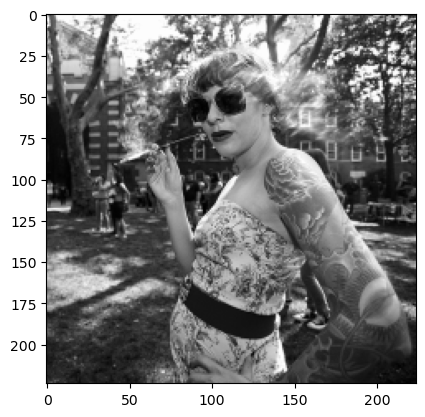

In [9]:
import cv2
import matplotlib.pyplot as plt
img = gray_images[0]
plt.imshow(img,'gray')

In [10]:
X_train = gray_images[:400,:,:].astype("float32").reshape(400,224,224)
X_test = gray_images[400:800,:,:].astype("float32").reshape(400,224,224)
y_train = ab_images[:400,:,:].astype("float32")
y_test = ab_images[400:800].astype("float32")

In [11]:
X_train.shape

(400, 224, 224)

In [12]:
X_train_norm = (X_train - np.mean(X_train))/255.0
y_train_norm = (y_train - np.mean(y_train))/255.0
X_train_norm = X_train_norm.reshape(400,224,224,1)

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, BatchNormalization
from keras.models import Sequential


## Model 1 on normalized LAB images

In [26]:
e_model = Sequential()
e_model.add(Conv2D(32,(3,3),padding ='same',activation='relu',input_shape =(224,224,1)))
e_model.add(BatchNormalization())
e_model.add(Conv2D(64,(3,3),padding ='same',activation='relu'))
e_model.add(BatchNormalization())
e_model.add(Conv2D(128,(3,3),padding ='same',activation='relu'))
e_model.add(layers.Dropout(0.5))
e_model.add(BatchNormalization())

g_model = Sequential()
g_model.add(layers.Conv2DTranspose(64,(3,3),padding ='same',activation='relu'))
g_model.add(layers.Conv2DTranspose(32,(3,3),padding ='same',activation='relu'))
g_model.add(layers.Conv2DTranspose(2,(3,3),padding ='same',activation='tanh'))


In [27]:
model = Sequential([e_model,g_model])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 128)     93568     
                                                                 
 sequential_10 (Sequential)  (None, 224, 224, 2)       92834     
                                                                 
Total params: 186,402
Trainable params: 185,954
Non-trainable params: 448
_________________________________________________________________


In [28]:
opt = keras.optimizers.RMSprop(lr=0.00001)
model.compile(optimizer=opt,loss = 'mse', metrics=['accuracy'])

model.fit(X_train_norm,y_train_norm,epochs=10,batch_size=32)

Epoch 1/10


2023-05-30 09:40:28.810780: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/sequential_9/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13/13 [==============================] - 11s 672ms/step - loss: 0.1319 - accuracy: 0.4929
Epoch 2/10
13/13 [==============================] - 9s 681ms/step - loss: 0.0055 - accuracy: 0.5022
Epoch 3/10
13/13 [==============================] - 9s 682ms/step - loss: 0.0049 - accuracy: 0.5056
Epoch 4/10
13/13 [==============================] - 9s 675ms/step - loss: 0.0047 - accuracy: 0.5066
Epoch 5/10
13/13 [==============================] - 9s 665ms/step - loss: 0.0047 - accuracy: 0.5075
Epoch 6/10
13/13 [==============================] - 9s 658ms/step - loss: 0.0046 - accuracy: 0.5076
Epoch 7/10
13/13 [==============================] - 9s 655ms/step - loss: 0.0046 - accuracy: 0.5077
Epoch 8/10
13/13 [==============================] - 8s 652ms/step - loss: 0.0046 - accuracy: 0.5078
Epoch 9/10
13/13 [==============================] - 9s 653ms/step - loss: 0.0046 - accuracy: 0.5077
Epoch 10/10
13/13 [==============================] - 9s 654ms/step - loss: 0.0046 - accuracy: 0.5077


## Model 2 on RGB images

In [40]:
def gray_dim(gray_images,size,preprocess_function=preprocess_input):
    zeros_dim = np.zeros((size,224,224,3))
    for i in range(3):
        zeros_dim[:size,:,:,i] = gray_images[:size]
    return preprocess_function(zeros_dim)
    #return zeros_dim

input_img = gray_dim(X_train,400)
test_img = gray_dim(X_test,400)

In [41]:
def abgray2rgb(gray_images,ab_images,n):
    rgb_img = np.zeros((n,224,224,3))
    rgb_img[:,:,:,0] = gray_images[0:n:]
    rgb_img[:,:,:,1:] = ab_images[0:n:]
    rgb_img = rgb_img.astype("uint8")
    out_img = []
    for i in range(n):
        out_img.append(cv2.cvtColor(rgb_img[i],cv2.COLOR_LAB2LRGB))
    out_img=np.array(out_img)
    return out_img

In [42]:
output_img = preprocess_input(abgray2rgb(X_train,y_train,400))

In [43]:
output_img.shape

(400, 224, 224, 3)

In [ ]:
e_model = Sequential()
e_model.add(Conv2D(32,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.ReLU())
e_model.add(Conv2D(64,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.ReLU())
e_model.add(Conv2D(128,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.ReLU())
e_model.add(Conv2D(256,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.ReLU())

g_model = Sequential()
g_model.add(layers.Conv2DTranspose(128,(2,2),padding ='same',use_bias=True))
g_model.add(layers.ReLU())
g_model.add(layers.Conv2DTranspose(64,(2,2),padding ='same',use_bias=True))
g_model.add(layers.ReLU())
g_model.add(layers.Conv2DTranspose(32,(2,2),padding ='same',use_bias=True))
g_model.add(layers.ReLU())
g_model.add(layers.Conv2DTranspose(3,(2,2),padding ='same',use_bias=True))
g_model.add(layers.ReLU())


In [ ]:
model = Sequential([e_model,g_model])

In [ ]:
model.summary()

In [14]:
opt = keras.optimizers.RMSprop(lr=0.0001)
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

model.compile(optimizer=opt,loss = 'mse', metrics=['accuracy'])

model.fit(input_img,output_img,epochs=10,callbacks=[Early_Stopper,Checkpoint_Model],batch_size=16)

Epoch 1/10
25/25 [==============================] - 38s 620ms/step - loss: 0.6943 - accuracy: 0.5510
Epoch 2/10
25/25 [==============================] - 16s 629ms/step - loss: 0.6166 - accuracy: 0.5867
Epoch 3/10
25/25 [==============================] - 16s 641ms/step - loss: 0.6167 - accuracy: 0.5880
Epoch 4/10
25/25 [==============================] - 16s 654ms/step - loss: 0.6018 - accuracy: 0.6132
Epoch 5/10
25/25 [==============================] - 17s 668ms/step - loss: 0.6012 - accuracy: 0.6215
Epoch 6/10
25/25 [==============================] - 17s 672ms/step - loss: 0.5973 - accuracy: 0.6203
Epoch 7/10
25/25 [==============================] - 17s 663ms/step - loss: 0.5987 - accuracy: 0.6223
Epoch 8/10
25/25 [==============================] - 16s 657ms/step - loss: 0.5932 - accuracy: 0.6265
Epoch 9/10
25/25 [==============================] - 16s 657ms/step - loss: 0.5960 - accuracy: 0.6270
Epoch 10/10
25/25 [==============================] - 16s 660ms/step - loss: 0.5953 - accura

## Model 3 with last layers as tanh

In [44]:
e_model = Sequential()
e_model.add(Conv2D(32,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.LeakyReLU())
e_model.add(Conv2D(64,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.LeakyReLU())
e_model.add(Conv2D(128,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.LeakyReLU())
e_model.add(Conv2D(256,(2,2),padding ='same',kernel_initializer = 'he_normal',use_bias=True))
e_model.add(BatchNormalization())
e_model.add(layers.LeakyReLU())

g_model = Sequential()
g_model.add(layers.Conv2DTranspose(128,(2,2),padding ='same',use_bias=True))
g_model.add(layers.LeakyReLU())
g_model.add(layers.Conv2DTranspose(64,(2,2),padding ='same',use_bias=True))
g_model.add(layers.LeakyReLU())
g_model.add(layers.Conv2DTranspose(32,(2,2),padding ='same',use_bias=True))
g_model.add(layers.LeakyReLU())
g_model.add(layers.Conv2DTranspose(3,(2,2),padding ='same',use_bias=True, activation='tanh'))


In [46]:
model = Sequential([e_model,g_model])

In [47]:
opt = keras.optimizers.RMSprop(lr=0.0001)
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

model.compile(optimizer=opt,loss = 'mse', metrics=['accuracy'])

model.fit(input_img,output_img,epochs=10,callbacks=[Early_Stopper,Checkpoint_Model],batch_size=16)

Epoch 1/10
25/25 [==============================] - 22s 775ms/step - loss: 0.1358 - accuracy: 0.4404
Epoch 2/10
25/25 [==============================] - 19s 775ms/step - loss: 0.0736 - accuracy: 0.4523
Epoch 3/10
25/25 [==============================] - 18s 734ms/step - loss: 0.0553 - accuracy: 0.5047
Epoch 4/10
25/25 [==============================] - 18s 723ms/step - loss: 0.0534 - accuracy: 0.5468
Epoch 5/10
25/25 [==============================] - 18s 735ms/step - loss: 0.0511 - accuracy: 0.5554
Epoch 6/10
25/25 [==============================] - 19s 749ms/step - loss: 0.0494 - accuracy: 0.5768
Epoch 7/10
25/25 [==============================] - 19s 749ms/step - loss: 0.0487 - accuracy: 0.5540
Epoch 8/10
25/25 [==============================] - 19s 743ms/step - loss: 0.0432 - accuracy: 0.5699
Epoch 9/10
25/25 [==============================] - 18s 739ms/step - loss: 0.0425 - accuracy: 0.5572
Epoch 10/10
25/25 [==============================] - 18s 738ms/step - loss: 0.0407 - accura